# Scotch Whisky Tasting Note Exploration

## Exploratory Data Analysis

In [164]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import ast
import itertools
from PIL import Image

In [165]:
sns.set_context("notebook")
sns.set_palette('tab10')

In [325]:
eda_image_path = "images\\EDA\\"

We did EDA on the dataframe where we treated the nose, palate, and finish as separate corpuses. My conclusion was that it makes the descriptors oversparse given the high correlations between these columns. I'm going to go ahead with just the unified token/BoW set.

In [315]:
whisk_interdf_path = "data\\interim\\whiskunified_bow_encoded.csv"

whisk_data = pd.read_csv(whisk_interdf_path)

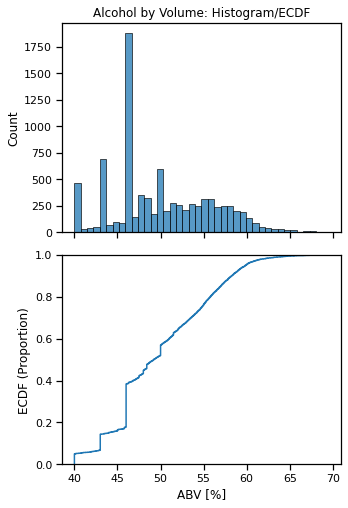

In [316]:
fig, axs = plt.subplots(2,1, figsize=(5, 7), sharex = True)


sns.histplot(whisk_data.ABV, bins = 40, ax = axs[0])
sns.ecdfplot(whisk_data.ABV, ax = axs[1])
axs[1].set_ylabel('ECDF (Proportion)')
axs[1].set_xlabel('ABV [%]')
plt.tight_layout()
axs[0].set_title("Alcohol by Volume: Histogram/ECDF")
plt.show()

There are some interesting features in the ABV:

1. There are no scotches below 40% ABV. This turns out to be due to a legal requirement in Scotland.
2. At <= 50 % ABV there seems to be a set of discrete steps in the ECDF with a particularly large jump at 46% ABV. This means that a lot of Scotches are bottled by manufacturers at exactly at 46% ABV. 
3. These discrete jumps suggest cutting the ABVs into ranges where ranges are the plateaus.

## Distribution: Whisky Aging Time

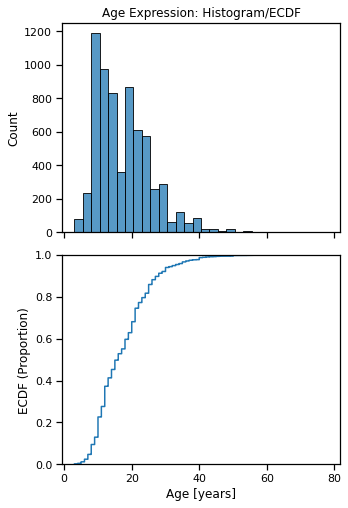

In [317]:
fig, axs = plt.subplots(2,1, figsize=(5, 7), sharex = True)


sns.histplot(whisk_data.age, bins = 30, ax = axs[0])
sns.ecdfplot(whisk_data.age, ax = axs[1])
axs[1].set_ylabel('ECDF (Proportion)')
axs[1].set_xlabel('Age [years]')
plt.tight_layout()
axs[0].set_title("Age Expression: Histogram/ECDF")
plt.show()

## Maturation Breakdown

In [318]:
whisk_data.columns[whisk_data.columns.str.contains('maturation')]


Index(['maturation_bourbon', 'maturation_brandy', 'maturation_marsala',
       'maturation_oak', 'maturation_port', 'maturation_red wine',
       'maturation_rum', 'maturation_rye', 'maturation_sauternes',
       'maturation_sherry', 'maturation_white wine', 'maturation_wine'],
      dtype='object')

In [319]:
maturation_cols = whisk_data.columns[whisk_data.columns.str.contains('maturation')]
maturation_subset = whisk_data[maturation_cols]
maturation_subset.head(3)

,maturation_bourbon,maturation_brandy,maturation_marsala,maturation_oak,maturation_port,maturation_red wine,maturation_rum,maturation_rye,maturation_sauternes,maturation_sherry,maturation_white wine,maturation_wine
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [320]:
cask_count = maturation_subset.sum(axis=0).sort_values(ascending = False)
print(cask_count)

maturation_sherry        1657.0
maturation_bourbon       1458.0
maturation_oak            543.0
maturation_wine           320.0
maturation_port           134.0
maturation_red wine        61.0
maturation_sauternes       43.0
maturation_rum             40.0
maturation_marsala         29.0
maturation_rye              9.0
maturation_brandy           5.0
maturation_white wine       3.0
dtype: float64


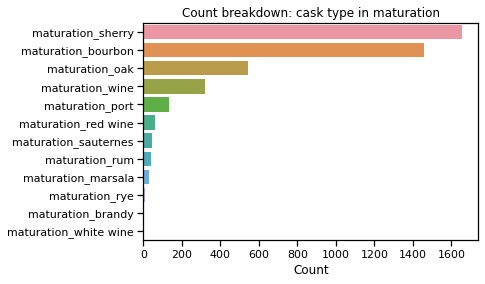

In [321]:
sns.barplot(y = list(cask_count.index), x = cask_count.values)
plt.title('Count breakdown: cask type in maturation')
plt.xlabel('Count')
plt.show()

Sherry and bourbon cask aging seem to be the dominant ones out of the whiskies from which we could extract descriptions (which is probably a representative sample of the population). Wine cask maturation (red wine, sauternes, and marsala are part of this class) and port are the next most frequent cask maturation / finishes. Surprisingly, there are not that many rum finishes present in the counting.

Next, let's check to see if there any correlation between the types of casks used in the aging process.

<AxesSubplot:>

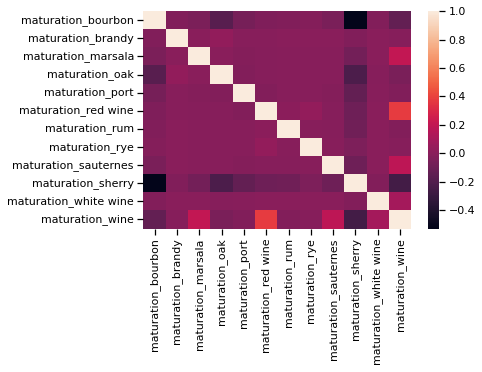

In [322]:
sns.heatmap(maturation_subset.corr())

A few thing pops out: 
1. Sherry and bourbon maturation are highly anticorrelated. This means that the two cask types tend to be mutually exclusive for the maturation of scotches.
2. There is clearly some co-occurence between oak maturation and bourbon maturation. The same goes for sherry and oak maturation.
3. Marsala, red wine, and Sauternes all have positive correlation with the general wine maturation class. This is comforting as they are all wines.


Checking the number of whiskies in the intersection of the sherry AND bourbon maturation reveals that there are whiskies that are matured in both cask types, but that by and large scotches are aged in one or the other.

In [174]:
((maturation_subset.maturation_sherry == 1) & (maturation_subset.maturation_bourbon == 1) ).sum()

183

## Word Cloud Visualization

There is some value in visualizing the count distribution for tokens using wordclouds to get a feel for what descriptors are relevant/prominent. 

In [329]:
def wd_cld_descriptor(data, col_name):

    # we want a flattened list of all the tokens for the wordcloud generator
    attr_listed = [ast.literal_eval(row) for row in data[col_name] ]
    attr_flattened = list(itertools.chain.from_iterable(attr_listed))
    
    attr_string=(" ").join(attr_flattened)
    mask = np.array(Image.open('whiskey_bottle.jfif'))
    wordcloud = WordCloud(background_color = "black", mask=mask, contour_color = 'red', width=mask.shape[1], height=mask.shape[0]).generate(attr_string)
    # wordcloud = WordCloud(background_color = "black").generate(attr_string)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud)

    
    title_name = "Scotch descriptors" 

    font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

    plt.title(title_name, fontdict=font)
    plt.axis("off")

    

    plt.savefig(eda_image_path + "wc_"+ col_name + ".jpg", dpi = 300, bbox_inches='tight')
    plt.show()
    plt.close()

In [330]:
whisk_token_path = "data\\interim\\whisk_unified_tokenized.csv"

whisk_tok_df = pd.read_csv(whisk_token_path)

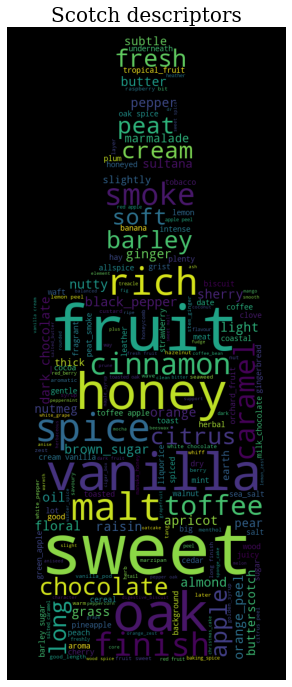

In [331]:
 wd_cld_descriptor(whisk_tok_df, "token_unified")

These mostly seem like good descriptors for a scotch.

One thing to note is that sweet descriptors seem to be prevalent at the top of the wordcloud. "Sweet", "vanilla", "honey", "cinnamon", "fruit", "caramel". It could be good to see why this is the case (i.e. are these common descriptors of all scotches in the collection? or are they characteristics of a subgroup that is a very large presence within the entire collection?). 

## Parsing sensory descriptions across Scotch whisky producing regions
Scotches from different regions are known to have different characteristics. Let's see if we can visualize some of these differences.

In [347]:
# we have 477 descriptors in the unified corpus
col_series = list(whisk_data.columns[-477::])
col_series.append('region')
df_subset = whisk_data[col_series]
BoWbyregion = df_subset.groupby('region').sum().reset_index()

BoWbyregion


,region,barley,butter,cereal,cut_grass,fruit,good_length,hay,malt,nut,...,exotic_spice,strawberry_jam,cracker,fizz,tangerine,porridge_oats,right,salty_butter,coriander,lightly
0,Campbeltown Whisky,27.0,18.0,11.0,1.0,105.0,3.0,3.0,51.0,9.0,...,1.0,4.0,2.0,0.0,1.0,2.0,2.0,2.0,4.0,1.0
1,Highland Whisky,520.0,260.0,138.0,14.0,979.0,39.0,79.0,745.0,117.0,...,17.0,42.0,12.0,13.0,16.0,18.0,13.0,9.0,11.0,11.0
2,Island Whisky,147.0,60.0,47.0,3.0,273.0,13.0,14.0,184.0,29.0,...,2.0,5.0,4.0,6.0,4.0,1.0,9.0,9.0,8.0,6.0
3,Islay Whisky,288.0,151.0,47.0,4.0,698.0,34.0,52.0,368.0,58.0,...,12.0,12.0,17.0,10.0,5.0,3.0,16.0,31.0,11.0,11.0
4,Lowland Whisky,78.0,30.0,29.0,5.0,161.0,17.0,15.0,124.0,12.0,...,4.0,5.0,3.0,2.0,5.0,4.0,0.0,3.0,4.0,5.0
5,Other Scotch Whisky,12.0,4.0,3.0,0.0,15.0,2.0,2.0,12.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Scotch Whisky,61.0,33.0,20.0,3.0,141.0,14.0,8.0,95.0,10.0,...,7.0,3.0,1.0,2.0,2.0,0.0,1.0,2.0,0.0,5.0
7,Speyside Whisky,964.0,541.0,219.0,37.0,1732.0,91.0,150.0,1364.0,232.0,...,29.0,60.0,17.0,39.0,25.0,29.0,20.0,13.0,22.0,30.0


We'll loop through and save the top 50 most frequent words in each region:

In [417]:
word_cnt_byregion = pd.melt(BoWbyregion, id_vars =['region']).set_index(['region', 'variable']).sort_index().rename(columns = {'value': 'Frequency'})
word_cnt_byregion.index = word_cnt_byregion.index.set_names(['Region', 'Word'])
region_names = word_cnt_byregion.index.get_level_values(0).unique()
print(region_names)

Index(['Campbeltown Whisky', 'Highland Whisky', 'Island Whisky',
       'Islay Whisky', 'Lowland Whisky', 'Other Scotch Whisky',
       'Scotch Whisky', 'Speyside Whisky'],
      dtype='object', name='Region')


There are 6 actual regions here: Speyside, Lowland, Islay, Island (the other islands besides Islay), Highland, and Campbeltown. Let's select these only.

In [428]:
true_regions = region_names.drop(['Other Scotch Whisky', 'Scotch Whisky'])
print(true_regions)

Index(['Campbeltown Whisky', 'Highland Whisky', 'Island Whisky',
       'Islay Whisky', 'Lowland Whisky', 'Speyside Whisky'],
      dtype='object', name='Region')


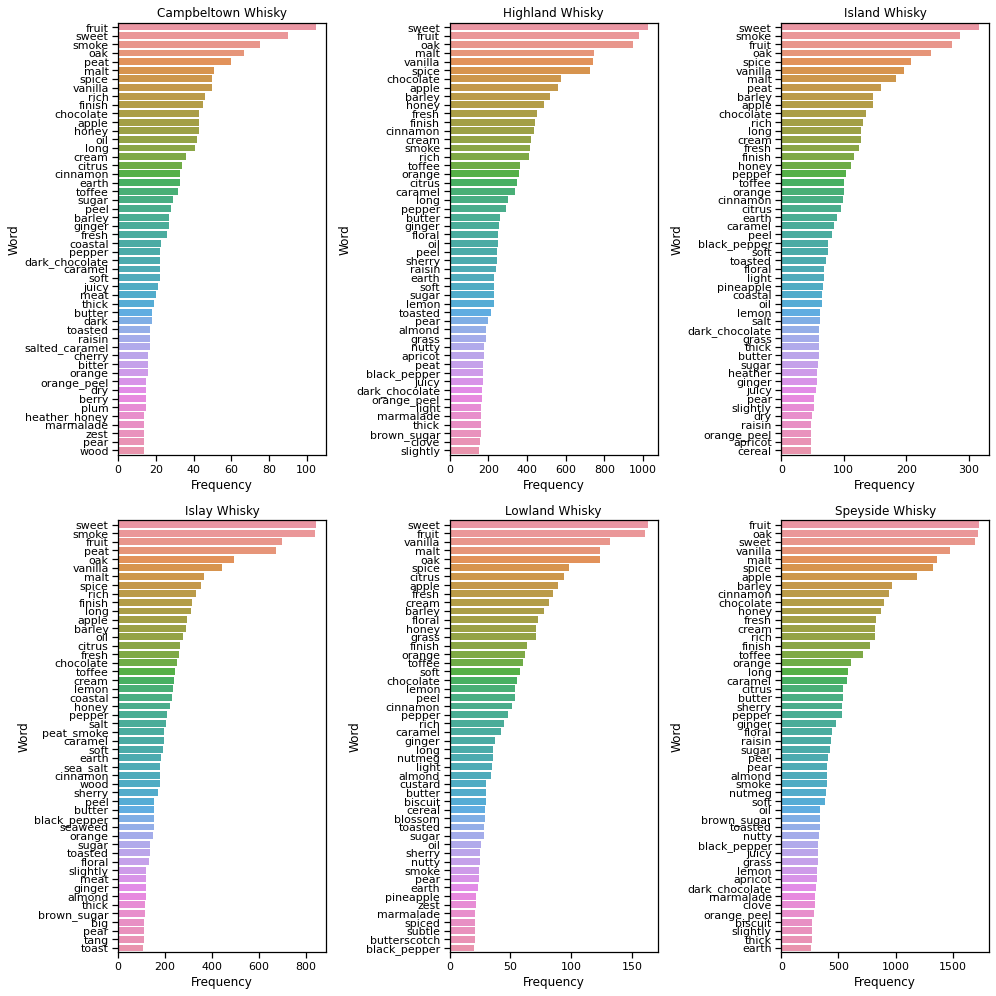

In [481]:
name_shaped = true_regions.to_numpy().reshape(2,3)
nrow, ncol = name_shaped.shape
index_list = list(itertools.product(list(range(nrow)), list(range(ncol)))) # will be used as iterable for subplot
fig, ax = plt.subplots(ncols=3, nrows=2, figsize = (14,14))
for index in index_list:
    name = name_shaped[index]
    topfreqdata = word_cnt_byregion.loc[name].sort_values(by = "Frequency", ascending = False)[0:50]
    sns.barplot(x = 'Frequency', y =topfreqdata.index, data = topfreqdata, ax = ax[index])
    ax[index].set_title(name)
    
plt.tight_layout()
plt.savefig(eda_image_path+'topwordsbyregion.jpg', dpi = 300)



There is a lot of information here. One thing to note is the scale of word frequency for Speyside whiskies. There are a lot more of these than any other region. A little research shows that this is representative of the fact that the Speyside region is the largest Scotch region with the most distilleries in the country. Speyside accounts for over half of the distilleries in Scotland.

The descriptors like 'sweet', 'vanilla', 'malt', 'spice', 'fruit', 'oak', 'apple', 'barley' are in the most frequent descriptors across ALL regions. That means that across the regions, there are many whiskies that contain these characteristics...they're not region specific.

However, there are region specific characteristics. To see this, let's focus on the bottom three regions (Islay, Lowland, and Speyside). Islay whisky has notes that are not prevalent in the other two regions: 'peat', 'smoke'. 'oil' are very high up in the Islay descriptor list whereas they are much less prominent in Speyside and Lowland whiskies. We can also see that Islay has descriptors in the top 50 that are not present in the other two classes for their top 50: 'coastal', 'salt', 'sea_salt', 'seaweed', 'meat'.

Meanwhile Speysides have descriptors like 'cinnamon', 'chocolate', 'toffee', 'honey', 'caramel', 'rich', 'cream', 'sherry'. So we expect sweeter, rich, dessert-like flavors in these sorts of whiskies.

Lowland whisky has a similar profile as Speyside but not 'rich'. Instead we have words like 'light', 'soft', 'subtle'. 'Grass' is also much more prevalent than in Speysides. So we might expect subtle, fresh notes...whiskies that have sweetness and subtle spice but are light and grassier.

So these descriptors and their ranking by region do make some sense and give a feel for regional flavor. But we're not done. There are a LOT of commonalities between the regions. And within regions there are whiskies that have certain groups of notes that are pronounced while other groups that are within common descriptors of that region are not present in the whisky (e.g., one Speyside whisky is rich and creamy with chocolate, toffee, butter and sherry...on the other hand another is rich and creamy but with lots of citrus notes like orange and with apple spiced with ginger and pepper). These are both Speysides and they share certain qualities but not others. 

While regional distinction has value, we want to be able to understand whiskies in terms of descriptor groupings. This will help us get a dimensionally-reduced picture of the descriptor space, a more general picture of the regions, and of each whisky. This is what we want to look at next:


## Correspondence Analysis

In [484]:
from prince import CA

In [520]:
descript_selector = list(whisk_data.columns[-477::])
descript_selector.append('name')
descriptor_subset = whisk_data[descript_selector].set_index('name')
descriptor_subset.head()

,barley,butter,cereal,cut_grass,fruit,good_length,hay,malt,nut,oak,...,exotic_spice,strawberry_jam,cracker,fizz,tangerine,porridge_oats,right,salty_butter,coriander,lightly
name,,,,,,,,,,,,,,,,,,,,,
Singleton of Dufftown 12 Year Old,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Laphroaig 10 Year Old Sherry Oak Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GlenAllachie 15 Year Old,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Seaweed & Aeons & Digging & Fire & Cask Strength 10 Year Old (Batch 04),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Edradour 10 Year Old,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This is clearly in the form of a contingency table. Let's proceed with the Correspondence Analysis.

In [535]:
ca = CA(n_components=2, n_iter=10, random_state=42)
descriptor_subset.columns.rename('Descriptors', inplace = True)
descriptor_subset.index.rename('Whiskies', inplace = True)

In [536]:
ca = ca.fit(descriptor_subset)
ca_2Dword_embed =ca.column_coordinates(descriptor_subset)
ca_2Dword_embed.head()

,0,1
barley,-0.195442,0.022470
butter,-0.241373,-0.158729
cereal,0.371546,-0.089603
cut_grass,-0.589741,0.087540
fruit,0.424599,-0.264144


In [539]:
ca_2Dword_embed[0:100]

,0,1
barley,-0.195442,0.022470
butter,-0.241373,-0.158729
cereal,0.371546,-0.089603
cut_grass,-0.589741,0.087540
fruit,0.424599,-0.264144
...,...,...
jammy,-0.054652,-0.378140
marmalade,0.021351,-0.369105
mature_oak,-0.999946,0.229897
roasted_coffee,-0.602153,-0.517614


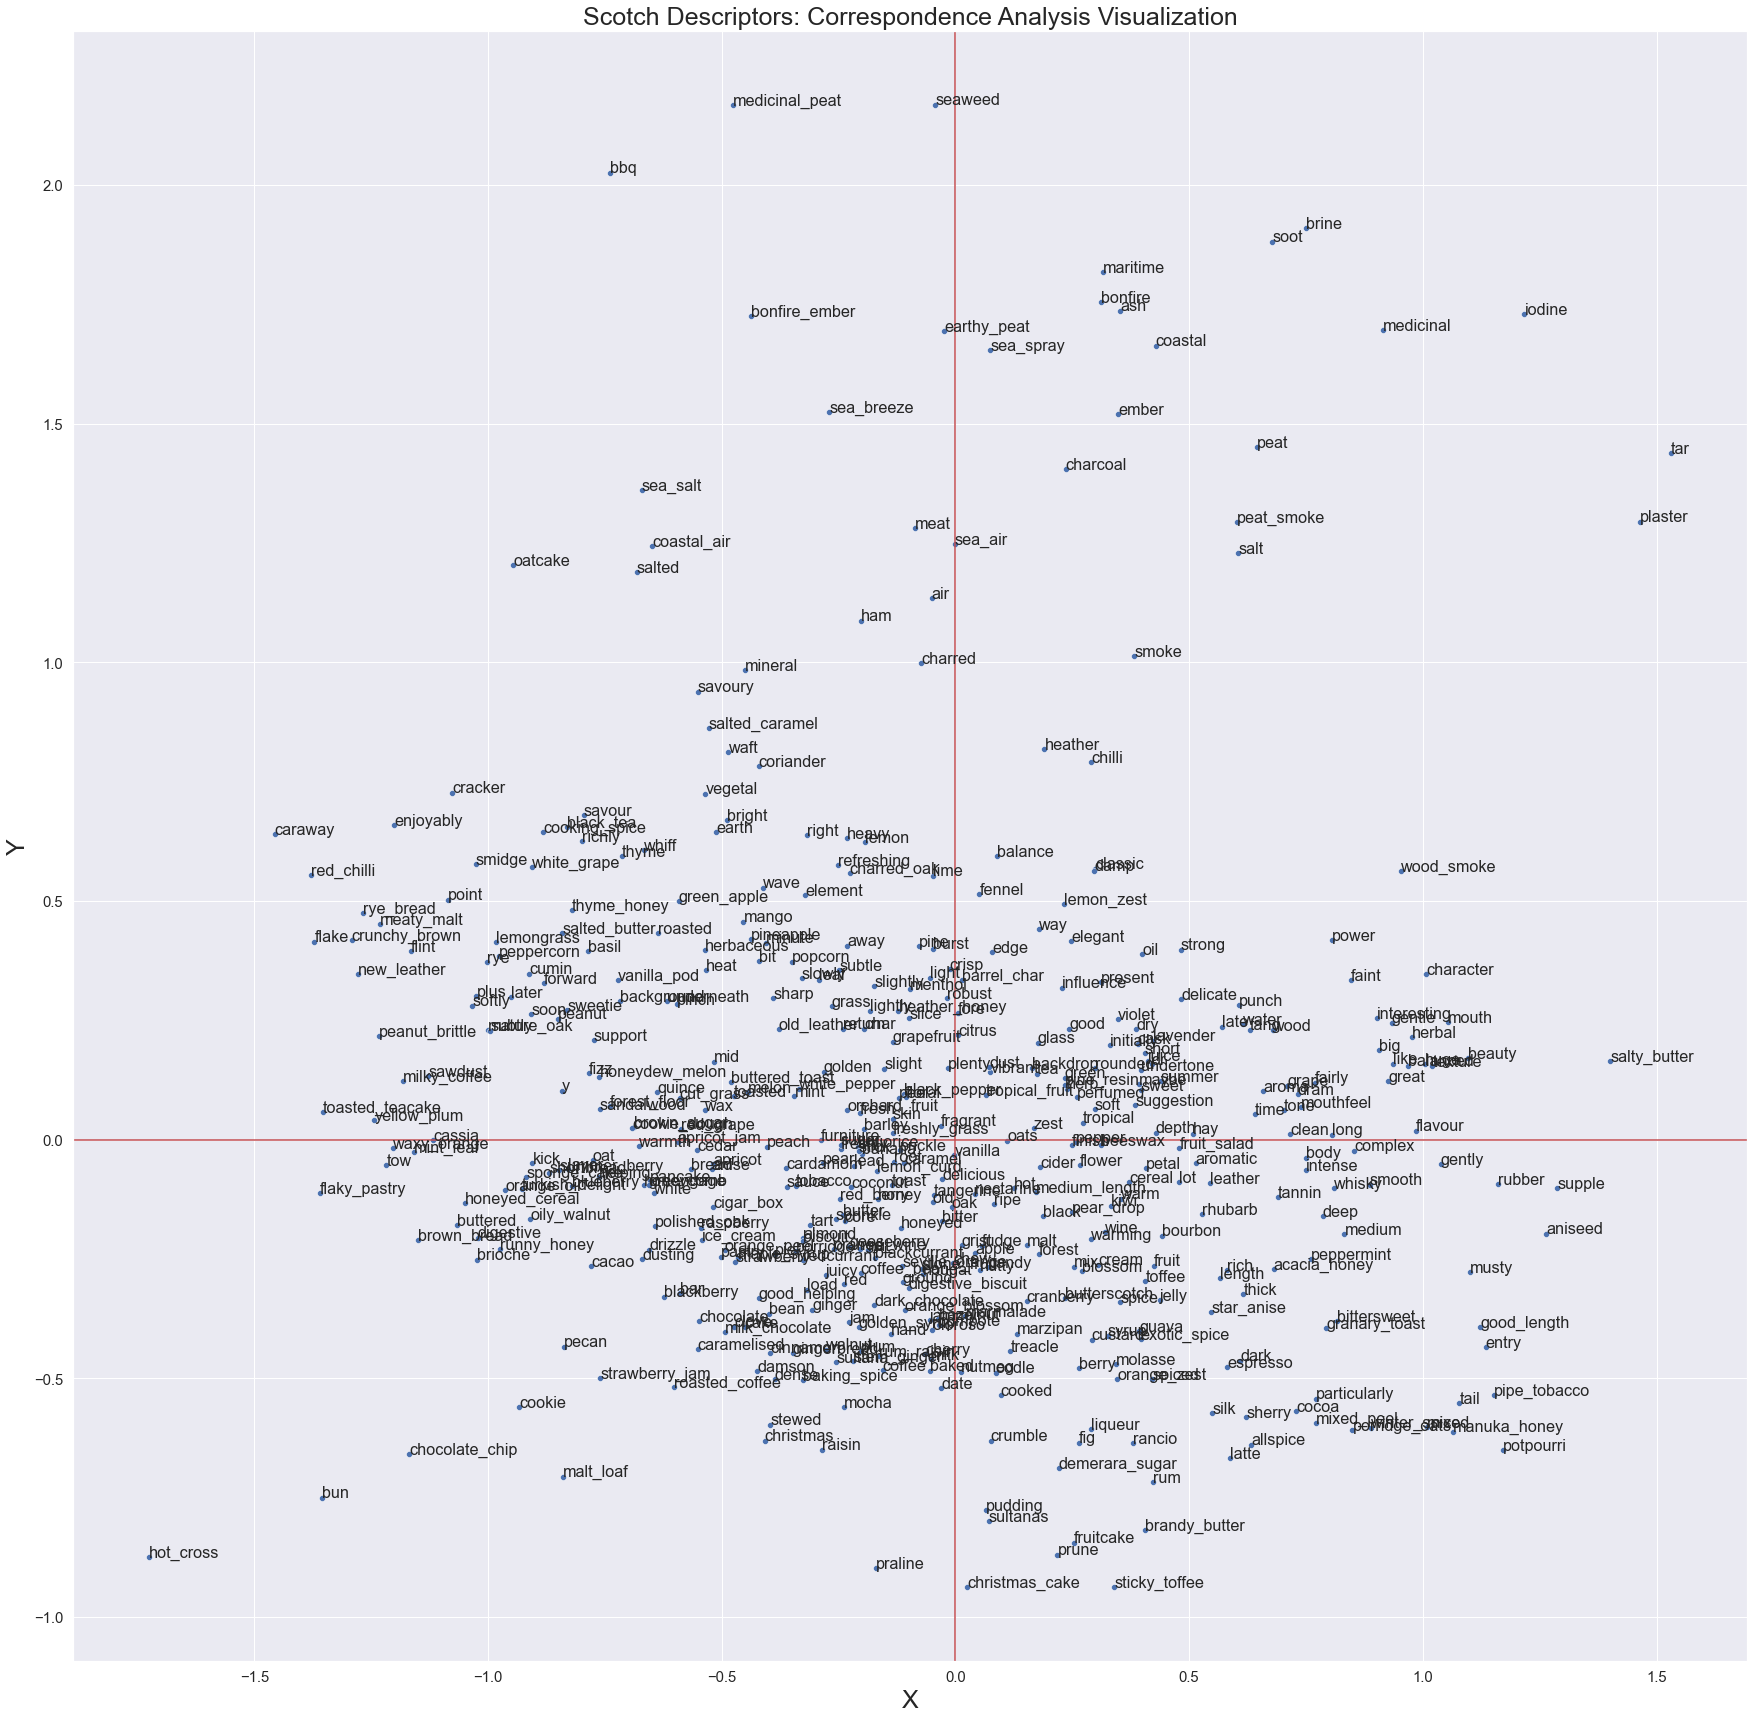

In [588]:
sns.set(font="Arial", font_scale = 1.35)
fig, ax = plt.subplots(figsize = (30,30))
sns.scatterplot(x = ca_2Dword_embed[0], y = ca_2Dword_embed[1])

for word_name in ca_2Dword_embed.index:
    plt.annotate(word_name, (ca_2Dword_embed.loc[word_name, 0], ca_2Dword_embed.loc[word_name, 1]) )

plt.axhline(y=0, c ='r')
plt.axvline(x=0, c = 'r')
plt.title("Scotch Descriptors: Correspondence Analysis Visualization", {'fontname':'Arial', 'fontsize': 25})
plt.xlabel('X', {'fontname':'Arial', 'fontsize': 25})
plt.ylabel('Y', {'fontname':'Arial', 'fontsize': 25})
plt.show()

This representation, which (loosely) keeps word that often co-occur in the corpus closer to each other in a lower dimensional space, is creating regions of descriptors that are recognizably similar/related in terms of sensory information (taste/smell/etc.). 

The region close to X=0 and Y< 0 thats at the bottom of the main cloud and below have pretty similar characteristics: 'christmas', 'raisin', 'christmas_cake', 'fruitcake', 'liqueur', 'pudding', sultanas', 'sticky_toffee', 'stewed', 'fig', 'rum', 'molasses', 'treacle', 'marzipan', 'date', 'nutmeg', 'baking spice', 'strawberry_jam', etc. --> These are all very thick, sweet, deep sugary, sweet-spice and holiday-like flavors.

As we go over larger X > 0 in the bottom right quandrant, the character changes. We have cocoa, mixed peel, aniseed, star anise, manuka honey, pipe tobacco, espresso, bittersweet. These are all tastes balanced between bitter and sweet or having notes of both.

As we go higher in Y, we start to get (roughly speaking) more astringent and sour notes: rhubarb, tannin, acacia, wine,...and going further up in Y and closer to X = 0: 'citrus', grapefruit', 'dry', 'grass', 'crisp', 'lemon_'zest', 'fennel'...etc.

Even higher as Y > 1, we also see a distinct set of flavors that are grouped together. These are salty, smoky, savory notes: "salt", "coastal", "seaweed", "iodine", "peat", "peat_smoke", "meat", "ham", "charred", "bbq", "bonfire", etc. 


In summary, in a rough sort of way we can say that increasing along Y we go from sweet/thick to sour/astringent/floral/aromatic to salty/savoury/smoky descriptors. This is more a continuum than clusters of distinct tastes...which makes sense given the complexity and multifaced nature of Scotches. So while we wont be able to do strict clustering (though visualizing an agglomerative hierarchical model might not be bad), we do have a sense that there are a few groups of descriptors. There is some overlap between the descriptor group regions, some ambiguity in some of the descriptors. This is a good candidate for topic modeling of the whiskey reviews via Latent Dirichlet Allocation (where we can guess topic numbers >= 3 based on our CA visualization).
